In [257]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [258]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-06.csv'

print(today_date_str)

_2024-03-21.csv


In [259]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1653 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3159644396863,USD,425.23,USD,428.99,USD,4.27,USD,1.004162,0.884227,7318745625.92,17860084,57803977,106969,22945552.9,21856413.5,24672276.72222223,1.259925,1.67029023,1.70465396,423.950000,38.45903389,Technology Services,0.72231057,0.9321239,1.0291758,0.8906199,5.015877,5.504585,3.410067,3.26306837,1.51780682,0.83353693,0.77016104,0.76344853,0.50759539,0.59138531,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,425.25,USD,425.25,USD,425.58,USD,425.58,USD,425.58,USD,425.96,USD,425.96,USD,425.96,USD,427.82,USD,958891.40271493,USD,424.822,424.583125,424.4250,424.893923,425.055810,424.33325,423.610690,425.950714,424.69632,423.441926
1,NVDA,NVIDIA Corporation,NASDAQ,2259299926758,USD,903.72,USD,916.09,USD,18.38,USD,2.033816,1.368787,2400415000,47904746,182020999,870652,67971393.6,59546789.76666665,48865368.10000013,2.478945,4.43372824,4.89813621,896.683333,75.71063545,Electronic Technology,0.78528545,1.8244131,2.3419523,1.7245569,2.643692,1.858086,1.310568,1.51649025,0.60781269,0.3204488,0.77634019,0.69421009,0.68673519,0.89379055,974,USD,974,USD,974,USD,974,USD,974.00000,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.10,USD,924.05,USD,974.00,USD,2058175.67567568,USD,902.955,902.283625,900.8644,900.490454,903.618601,901.13544,898.652279,904.682153,899.16898,893.655807
2,GOOG,Alphabet Inc.,NASDAQ,1854615155609,USD,149.68,USD,150.80,USD,0.74,USD,0.494388,0.748263,5274001645,17729953,83155052,90667,27210791.79999997,25089489.73333337,22976934.45555557,1.418752,2.04683976,2.12202324,149.035000,25.78378006,Technology Services,0.63940318,0.97195053,1.1586931,1.0489115,4.071962,3.392444,2.569182,2.47144697,1.24193606,0.51685776,0.62661095,0.63879484,0.72686897,0.81998993,152.93,USD,155.2,USD,155.2,USD,155.2,USD,155.20000,USD,149.70,USD,149.70,USD,149.70,USD,149.70,USD,149.70,USD,149.76,USD,149.76,USD,152.93,USD,152.93,USD,1683033.61059057,USD,149.627,149.551250,149.4200,149.475185,149.684859,149.45400,149.223141,149.877560,149.36367,148.849780
3,GOOGL,Alphabet Inc.,NASDAQ,1854615155609,USD,148.74,USD,149.81,USD,0.77,USD,0.517682,0.719376,5871125184,21311489,114655635,124097,36

In [260]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [261]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.159644e+12,USD,425.23,USD,428.99,USD,4.27,USD,1.004162,0.884227,7318745625.92,17860084,57803977,106969,22945552.9,21856413.5,24672276.72222223,1.259925,1.67029023,1.70465396,423.950000,38.45903389,Technology Services,0.72231057,0.9321239,1.0291758,0.8906199,5.015877,5.504585,3.410067,3.26306837,1.51780682,0.83353693,0.77016104,0.76344853,0.50759539,0.59138531,427.82,USD,427.82,USD,427.82,USD,427.82,USD,427.82000,USD,425.25,USD,425.25,USD,425.58,USD,425.58,USD,425.58,USD,425.96,USD,425.96,USD,425.96,USD,427.82,USD,958891.40271493,USD,424.822,424.583125,424.4250,424.893923,425.055810,424.33325,423.610690,425.950714,424.69632,423.441926,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,2.259300e+12,USD,903.72,USD,916.09,USD,18.38,USD,2.033816,1.368787,2400415000,47904746,182020999,870652,67971393.6,59546789.76666665,48865368.10000013,2.478945,4.43372824,4.89813621,896.683333,75.71063545,Electronic Technology,0.78528545,1.8244131,2.3419523,1.7245569,2.643692,1.858086,1.310568,1.51649025,0.60781269,0.3204488,0.77634019,0.69421009,0.68673519,0.89379055,974,USD,974,USD,974,USD,974,USD,974.00000,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.00,USD,904.10,USD,924.05,USD,974.00,USD,2058175.67567568,USD,902.955,902.283625,900.8644,900.490454,903.618601,901.13544,898.652279,904.682153,899.16898,893.655807,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.854615e+12,USD,149.68,USD,150.80,USD,0.74,USD,0.494388,0.748263,5274001645,17729953,83155052,90667,27210791.79999997,25089489.73333337,22976934.45555557,1.418752,2.04683976,2.12202324,149.035000,25.78378006,Technology Services,0.63940318,0.97195053,1.1586931,1.0489115,4.071962,3.392444,2.569182,2.47144697,1.24193606,0.51685776,0.62661095,0.63879484,0.72686897,0.81998993,152.93,USD,155.2,USD,155.2,USD,155.2,USD,155.20000,USD,149.70,USD,149.70,USD,149.70,USD,149.70,USD,149.70,USD,149.76,USD,149.76,USD,152.93,USD,152.93,USD,1683033.61059057,USD,149.627,149.551250,149.4200,149.475185,149.684859,149.45400,149.223141,149.877560,149.36367,148.849780,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.854615e+12,USD,148.74,USD,149.81,USD,0.77,USD,0.517682,0.719376,58711251

In [262]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [263]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1653 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Large caps,378,22.867514
1,Small caps,356,21.536600
2,Midlers,352,21.294616
3,Shrimp,279,16.878403
4,Micro caps,240,14.519056
5,Titans,35,2.117362
6,Undefined,13,0.786449


In [264]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1640 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
1281,ATRA,"Atara Biotherapeutics, Inc.",NASDAQ,9.302039e+07,USD,0.7200,USD,0.7380,USD,0.0075,USD,1.041667,2.500000,119966213.565,1376785,4070955,10483,2982276.5,2378382.16666667,5005260.82222222,13.811135,9.07254535,12.22067158,0.703400,-,Health Technology,1.07027546,2.837124,-0.5388402,0.7078448,2.451457,2.203879,2.635528,2.40097484,1.20781738,0.68912414,0.77346884,0.46303996,0.23540347,0.61835297,0.9375,USD,1.58,USD,1.83,USD,3.08,USD,65.5599,USD,0.7231,USD,0.7231,USD,0.7300,USD,0.7300,USD,0.7300,USD,0.7300,USD,0.7400,USD,0.7400,USD,0.83,USD,190338.32335329,USD,0.71866,0.718237,0.71836,0.711185,0.721530,0.716948,0.712367,0.721146,0.710100,0.699054,Micro caps
1081,MTC,"MMTec, Inc.",NASDAQ,3.803670e+08,USD,1.9100,USD,1.9100,USD,0.0228,USD,1.193717,0.000000,198782356.955,33590,188038,1117,239566.7,2736744.06666667,1222816.57777778,5.222826,12.96664327,24.90726397,1.895367,-,Technology Services,0.13133199,-5.19329,0.02367379,2.00099,1.464942,1.464942,0.684611,0.70024979,0.1878574,0.10884336,0.03622858,0.1167564,0.02199874,5.38171699,3.83,USD,3.83,USD,4.86,USD,4.86,USD,195.4950,USD,1.9100,USD,1.9100,USD,1.9100,USD,1.9100,USD,1.9100,USD,1.9100,USD,1.9361,USD,2.0599,USD,3.83,USD,19984.23636366,USD,1.89580,1.888550,1.89580,1.886023,1.937824,1.886000,1.834176,1.933443,1.888375,1.843307,Small caps
640,STRL,"Sterling Infrastructure, Inc.",NASDAQ,3.392245e+09,USD,109.6900,USD,112.0000,USD,1.8100,USD,1.650105,2.105935,29618625.2895,266418,838023,622,305013.3,409866.93333333,375051.13333333,3.576028,3.77893095,4.53414615,108.859967,24.62453699,Industrial Services,1.04751119,0.79557294,1.1756238,1.1908185,0.973839,1.297878,1.938071,2.82683493,1.46932925,0.74777226,1.34656719,0.87703855,0.438937,0.56570004,116.36,USD,116.36,USD,116.36,USD,116.36,USD,116.3600,USD,109.8600,USD,110.1100,USD,110.3499,USD,110.3499,USD,110.3499,USD,110.3499,USD,110.3499,USD,110.9799,USD,116.36,USD,657409.66666667,USD,109.72400,109.708125,109.75600,109.724831,110.098368,109.750000,109.401632,110.618371,109.310140,108.001909,Midlers
1424,DUO,Fangdd Network Group Ltd.,NASDAQ,2.578874e+07,USD,0.4831,USD,0.4755,USD,0.0069,USD,1.428276,-1.573173,-,123174,1005388,2

In [265]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [266]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [267]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1640
Number of rows removed: 1622
NEW DataFrame length: 18


In [268]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,12,66.666667
1,Midlers,5,27.777778
2,Small caps,1,5.555556


In [269]:
### ADD 'TSLA' TO THE DATAFRAME ####


In [270]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Large caps' 'Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative V

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,BKNG,Booking Holdings Inc. Common Stock,NASDAQ,1.222807e+11,USD,3578.49,USD,3624.00,USD,46.5100,USD,1.299710,1.271765,3.386852e+07,430452,849196,650,320103.3,341366.7,273421.71111111,3.513990,2.022650,2.147074,3567.166667,30.33132734,Consumer Services,1.736518,1.1672204,1.2610143,1.4031535,4.190700,1.765235,3.625571,3.69526702,2.57239259,1.71043306,2.64353374,1.431458,0.60161624,0.71722073,3918,USD,3918,USD,3918,USD,3918,USD,3918.0000,USD,3579.4200,USD,3609.67,USD,3617.2100,USD,3617.2100,USD,3617.2100,USD,3623.0000,USD,3623.0000,USD,3623.0000,USD,3623.0000,USD,905296.61016949,USD,3573.58400,3576.228750,3591.24800,3598.609231,3619.250905,3589.913500,3560.576095,3628.509575,3602.571000,3576.632425,Large caps
1,URI,"United Rentals, Inc.",NYSE,4.766104e+10,USD,709.33,USD,719.99,USD,10.6700,USD,1.504236,1.502827,6.679389e+07,1070645,1887833,304,598482,526675.33333333,646298.52222222,3.450102,2.447338,2.486891,705.402600,20.05762825,Finance,2.297910,2.14855,1.7291929,1.8389393,12.851938,2.890076,3.526713,1.87958956,1.34296658,1.03626951,1.344065,1.994874,0.64434017,0.52606719,732.3699,USD,732.3699,USD,732.3699,USD,732.3699,USD,732.3699,USD,710.4400,USD,710.96,USD,715.3678,USD,715.3678,USD,715.3678,USD,715.3678,USD,715.3678,USD,715.3678,USD,732.3699,USD,544942.96577947,USD,710.02300,709.942188,709.62250,711.334408,711.316648,709.752125,708.187602,716.191543,709.433875,702.676207,Large caps
2,ROK,"Rockwell Automation, Inc.",NYSE,3.228974e+10,USD,281.78,USD,283.02,USD,1.2400,USD,0.440060,0.440060,1.143522e+08,2011675,3906911,366,1050747.8,1158580.66666667,996106.44444444,8.331753,3.682087,2.655059,277.043333,26.80198604,Electronic Technology,3.017004,1.3337036,1.5122364,1.4295988,8.444594,8.123481,3.852564,1.31974733,0.88883237,0.65208165,1.27641338,2.168942,0.73554427,0.79204323,298.625,USD,312.755,USD,312.755,USD,348.52,USD,354.9900,USD,282.3750,USD,282.75,USD,283.9000,USD,283.9000,USD,283.9000,USD,285.6600,USD,285.6600,USD,285.6600,USD,298.6250,USD,312137.93103448,USD,282.09400,281.991875,282.07900,282.820000,282.804371,282.140750,281.477129,284.037324,282.420500,280.803676,Large caps
3,RKT,"Rocket Companies, Inc.",NYSE,2.68

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [271]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [272]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [273]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [274]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 18/18 [00:00<00:00, 1531.14it/s]


In [275]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-23
END date: 2024-03-20
103 days of historical stock data.

1854 = Length of dataframe
18 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['BKNG', 'URI', 'ROK', 'RKT', 'TTWO', 'MBLY', 'ARGX', 'TER', 'XPO', 'ACM', 'MNDY', 'SWAV', 'PARAA', 'FN', 'RH', 'SIG', 'SIMO', 'ROOT']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1844,44.50,45.490,41.0000,44.62,2024-03-07,ROOT,704930,HISTORICAL_PRICES,ROOT,,2024-03-07,1709863227000,3.847495,3.847495,44.62,44.50,45.490,41.0000,704930,44.62,44.50,45.490,41.0000,704930,"Mar 7, 24",0.38,0.0086,ROOT
1845,45.77,47.100,41.7600,44.03,2024-03-08,ROOT,646095,HISTORICAL_PRICES,ROOT,,2024-03-08,1709951439000,3.985839,3.985839,44.03,45.77,47.100,41.7600,646095,44.03,45.77,47.100,41.7600,646095,"Mar 8, 24",1.27,0.0285,ROOT
1846,42.65,48.380,41.6000,45.20,2024-03-11,ROOT,643823,HISTORICAL_PRICES,ROOT,,2024-03-11,1710230514000,3.645969,3.645969,45.20,42.65,48.380,41.6000,643823,45.20,42.65,48.380,41.6000,643823,"Mar 11, 24",-3.12,-0.0682,ROOT
1847,43.71,44.180,38.3100,42.99,2024-03-12,ROOT,666272,HISTORICAL_PRICES,ROOT,,2024-03-12,1710297030000,3.761438,3.761438,42.99,43.71,44.180,38.3100,666272,42.99,43.71,44.180,38.3100,666272,"Mar 12, 24",1.06,0.0249,ROOT
1848,46.77,47.320,42.8101,43.00,2024-03-13,ROOT,441435,HISTORICAL_PRICES,ROOT,,2024-03-13,1710381627000,4.094771,4.094771,43.00,46.77,47.320,42.8101,441435,43.00,46.77,47.320,42.8101,441435,"Mar 13, 24",3.06,0.0700,ROOT
1849,46.27,47.695,44.4800,47.16,2024-03-14,ROOT,323792,HISTORICAL_PRICES,ROOT,,2024-03-14,1710471650000,4.040305,4.040305,47.16,46.27,47.695,44.4800,323792,47.16,46.27,47.695,44.4800,323792,"Mar 14, 24",-0.50,-0.0107,ROOT
1850,52.89,53.370,45.1301,45.63,2024-03-15,ROOT,987168,HISTORICAL_PRICES,ROOT,,2024-03-15,1710552653000,4.761438,4.761438,45.63,52.89,53.370,45.1301,987168,45.63,52.89,53.370,45.1301,987168,"Mar 15, 24",6.62,0.1431,ROOT
1851,59.13,60.580,50.5013,53.00,2024-03-18,ROOT,1117686,HISTORICAL_PRICES,ROOT,,2024-03-18,1710813687000,5.441176,5.441176,53.00,59.13,60.580,50.5013,1117686,53.00,59.13,60.580,50.5013,1117686,"Mar 18, 24",6.24,0.1180,ROOT
1852,46.54,59.670,46.0200,59.40,2024-03-19,ROOT,1758110,HISTORICAL_PRICES,ROOT,,2024-03-19,1710903644000,4.069717,4.069717,59.40,46.54,59.670,46.0200,1758110,59.40,46.54,59.670,46.0200,1758110,"Mar 19, 24",-12.59,-0.2129,ROOT
1853,52.25,52.900,42.4600,43.50,2024-03-20,ROOT,1164792,HISTORICAL_PRICES,ROOT,,2024-03-20,1710983212000,4.691721,4.691721,43.50,52.25,52.900,42.4600,1164792,43.50,52.25,52.900,42.4600,1164792,"Mar 20, 24",5.71,0.1227,ROOT


In [276]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [277]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,ACM,2024-03-20,95.61,95.9300,93.6300,93.63,1238637
1,ARGX,2024-03-20,356.95,359.4300,349.8600,359.00,479044
2,BKNG,2024-03-20,3578.49,3623.0000,3500.0100,3510.08,430452
3,FN,2024-03-20,192.12,194.6300,186.6750,194.00,1062775
4,MBLY,2024-03-20,30.50,30.5500,28.7500,29.90,6687926
5,MNDY,2024-03-20,232.38,234.4100,223.2900,225.00,1010606
6,PARAA,2024-03-20,23.96,24.0200,21.5500,22.50,146618
7,RH,2024-03-20,290.06,296.1400,275.7900,276.74,646805
8,RKT,2024-03-20,13.50,13.5700,12.5000,12.60,3957502
9,ROK,2024-03-20,281.78,285.6600,263.6900,278.83,2011675


In [278]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 1854


In [279]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [280]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,BKNG,2023-10-23,2819.54,2841.460,2742.0000,2753.76,266771
309,RKT,2023-10-23,7.36,7.470,7.1900,7.25,1263330
1751,ROOT,2023-10-23,9.18,9.362,8.8674,9.12,23249
1339,FN,2023-10-23,162.94,164.890,158.6500,160.05,299745
721,TER,2023-10-23,90.92,92.810,90.6500,91.00,1325079


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [281]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-23,BKNG,2819.54,2841.460,2742.0000,2753.76,266771
2023-10-23,RKT,7.36,7.470,7.1900,7.25,1263330
2023-10-23,ROOT,9.18,9.362,8.8674,9.12,23249
2023-10-23,FN,162.94,164.890,158.6500,160.05,299745
2023-10-23,TER,90.92,92.810,90.6500,91.00,1325079


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [282]:
# filter by symbol
ticker = 'MNDY'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-03-07,MNDY,226.73,228.6200,222.3000,228.62,434605
2024-03-08,MNDY,220.45,229.7700,219.7200,224.34,409302
2024-03-11,MNDY,217.10,220.5800,216.0200,217.62,498932
2024-03-12,MNDY,224.74,225.8000,216.8400,217.83,579019
2024-03-13,MNDY,219.44,224.2008,219.2000,221.28,431659
2024-03-14,MNDY,217.58,220.4600,215.1000,219.47,383865
2024-03-15,MNDY,217.00,218.1100,213.2800,215.62,906483
2024-03-18,MNDY,223.22,223.5700,216.9675,220.41,240207
2024-03-19,MNDY,223.18,223.9700,214.9350,219.70,444466


In [283]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-07,MNDY,226.73,228.6200,222.3000,228.62,434605
2024-03-08,MNDY,220.45,229.7700,219.7200,224.34,409302
2024-03-11,MNDY,217.10,220.5800,216.0200,217.62,498932
2024-03-12,MNDY,224.74,225.8000,216.8400,217.83,579019
2024-03-13,MNDY,219.44,224.2008,219.2000,221.28,431659
2024-03-14,MNDY,217.58,220.4600,215.1000,219.47,383865
2024-03-15,MNDY,217.00,218.1100,213.2800,215.62,906483
2024-03-18,MNDY,223.22,223.5700,216.9675,220.41,240207
2024-03-19,MNDY,223.18,223.9700,214.9350,219.70,444466


In [284]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [285]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2023-10-23,MNDY,137.77,138.47,128.850,130.32,1012304
2023-10-24,MNDY,138.49,143.75,136.250,138.52,533361
2023-10-25,MNDY,128.66,138.04,127.800,138.04,507610
2023-10-26,MNDY,125.52,131.36,122.130,129.00,799413
2023-10-27,MNDY,129.24,130.16,125.555,128.10,579127
2023-10-30,MNDY,129.97,133.60,128.865,131.70,630813


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [286]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [287]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [288]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [289]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [290]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Identify the pivot points within the last 72 periods
pivot_point_low_index = last_72_df['Close'].idxmin()
pivot_point_high_index = last_72_df['Close'].idxmax()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [291]:
best_fit_last_72

array([178.58276256, 179.31999695, 180.05723133, 180.79446572,
       181.53170011, 182.2689345 , 183.00616889, 183.74340327,
       184.48063766, 185.21787205, 185.95510644, 186.69234083,
       187.42957521, 188.1668096 , 188.90404399, 189.64127838,
       190.37851277, 191.11574715, 191.85298154, 192.59021593,
       193.32745032, 194.06468471, 194.80191909, 195.53915348,
       196.27638787, 197.01362226, 197.75085665, 198.48809103,
       199.22532542, 199.96255981, 200.6997942 , 201.43702859,
       202.17426298, 202.91149736, 203.64873175, 204.38596614,
       205.12320053, 205.86043492, 206.5976693 , 207.33490369,
       208.07213808, 208.80937247, 209.54660686, 210.28384124,
       211.02107563, 211.75831002, 212.49554441, 213.2327788 ,
       213.97001318, 214.70724757, 215.44448196, 216.18171635,
       216.91895074, 217.65618512, 218.39341951, 219.1306539 ,
       219.86788829, 220.60512268, 221.34235706, 222.07959145,
       222.81682584, 223.55406023, 224.29129462, 225.02

In [292]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING |
|-|
| Extending the trend and regression lines to the future |

In [293]:
# # Extend x_values for future predictions
# future_line_periods = 10
# current_periods = len(ticker_df)
# extended_x_values = np.arange(current_periods + future_line_periods)

# # Calculate extended trend lines
# extended_support_line = support_coefs[0] * extended_x_values + support_coefs[1]
# extended_resistance_line = resist_coefs[0] * extended_x_values + resist_coefs[1]

# # Calculate extended line of best fit
# X_future = np.arange(-72, future_line_periods).reshape(-1, 1)  # -72 for last 72 periods and future periods
# extended_best_fit = model.predict(X_future).flatten()

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [294]:
# prepare the plot
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]

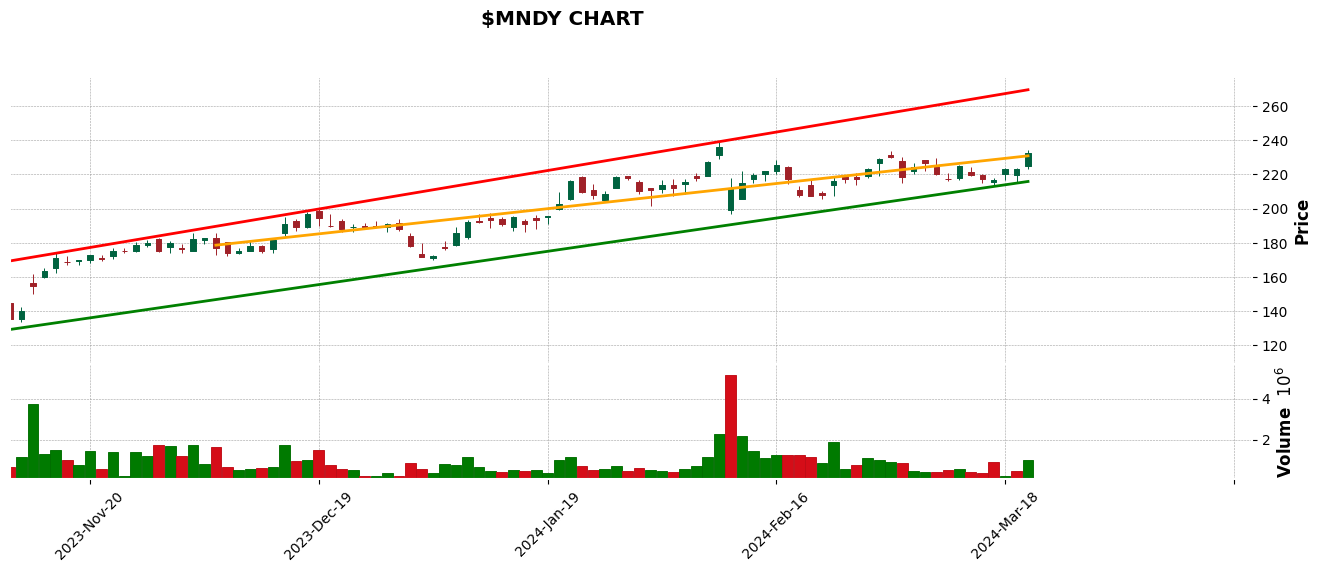

In [295]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [296]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-03-07,MNDY,226.73,228.6200,222.3000,228.62,434605
2024-03-08,MNDY,220.45,229.7700,219.7200,224.34,409302
2024-03-11,MNDY,217.10,220.5800,216.0200,217.62,498932
2024-03-12,MNDY,224.74,225.8000,216.8400,217.83,579019
2024-03-13,MNDY,219.44,224.2008,219.2000,221.28,431659
2024-03-14,MNDY,217.58,220.4600,215.1000,219.47,383865
2024-03-15,MNDY,217.00,218.1100,213.2800,215.62,906483
2024-03-18,MNDY,223.22,223.5700,216.9675,220.41,240207
2024-03-19,MNDY,223.18,223.9700,214.9350,219.70,444466


In [297]:
support_line

array([116.50967085, 117.48415187, 118.45863289, 119.4331139 ,
       120.40759492, 121.38207593, 122.35655695, 123.33103797,
       124.30551898, 125.28      , 126.25448102, 127.22896203,
       128.20344305, 129.17792407, 130.15240508, 131.1268861 ,
       132.10136711, 133.07584813, 134.05032915, 135.02481016,
       135.99929118, 136.9737722 , 137.94825321, 138.92273423,
       139.89721525, 140.87169626, 141.84617728, 142.82065829,
       143.79513931, 144.76962033, 145.74410134, 146.71858236,
       147.69306338, 148.66754439, 149.64202541, 150.61650643,
       151.59098744, 152.56546846, 153.53994947, 154.51443049,
       155.48891151, 156.46339252, 157.43787354, 158.41235456,
       159.38683557, 160.36131659, 161.33579761, 162.31027862,
       163.28475964, 164.25924065, 165.23372167, 166.20820269,
       167.1826837 , 168.15716472, 169.13164574, 170.10612675,
       171.08060777, 172.05508879, 173.0295698 , 174.00405082,
       174.97853184, 175.95301285, 176.92749387, 177.90

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [298]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [299]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [300]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [301]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [302]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [303]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [304]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [305]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [306]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [307]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [308]:
# chart_historical_df.head(5)

In [309]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [310]:
# # date column check data type
# chart_historical_df.index

In [311]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [312]:
# chart_historical_df.index

In [313]:
# chart_historical_df.head(5)

In [314]:
# print(tv_L2_df.columns)

In [315]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [316]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [317]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [318]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [319]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [320]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [321]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [322]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [323]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [324]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [325]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [326]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [327]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [328]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [329]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [330]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [331]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [332]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [333]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [334]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)